# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!

results_dir = "/gdrive/MyDrive/Computational Intelligence/"


In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits() # import dataset
        # load digits would contain some parameter
        # data (1797,64)
        # targets (1797,)
        if mode == "train":
            # 55% for training
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            # 20% (350 points) for validation
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            # rest for testing
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

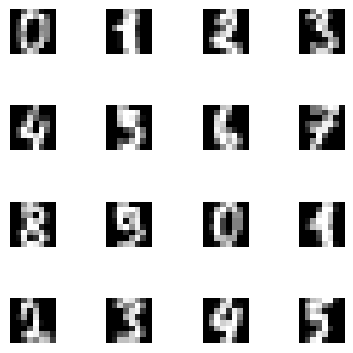

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        # reshape image from a vector 
        # to a 8x8 tensor
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

In [ ]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
print(f"input: {input.shape}")
output = m(input)
print(f"output: {output.shape}")

input: torch.Size([20, 16, 50, 100])
output: torch.Size([20, 33, 26, 100])


## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [ ]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        # np.prod would return a product of
        # all elements in a list
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)
  


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        # input: a batch of 64 images [64,64]
        # output: a batch of 64 labels [64,1]
        # prediction would be the index of the maximum element
        # of a tensor (10)
        y_pred = torch.argmax(self.classnet(x), dim = 1)

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        # loss would be negative log-likelihood of 
        # the prediction and actual values
        output = self.classnet(x) # prediction
        loss = self.nll(output,y)
        # ------
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Please write it in mathematical terms.

**Answer:**
The objective function for the classification task is Negative Log Likelihood Loss in minibatch 

The mathematical term:
$${l(θ)} = {-\sum_{i=1}^{N}(y_{i}log\hat{y_{θ,i}}+(1-y_{i})log(1-\hat{y_{θ,i}})} $$

For one batch, the loss can either be the sum or mean of all loss points in the batch:

if reduction = "mean":
$$l(x,y) = \sum_{i=1}^{K} {1 \over \sum_{i=1}^{K} w_{yk} }l_{k}$$

if reduction = "sum":
$$l(x,y) = \sum_{i=1}^{K}l_{k} $$

where K is the batch size

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:**

The substitution of Log Softmax for Softmax brings a wealth of benefits to the gradient computation. The main role of both layers is computing the probability of an event and if we imagine that a probability of multiple indepedent events would be the multiplication of such events with the use of the normal Softmax. However, the log operator would transform such complicated multiplication into simpler addition operators, computing the probability with the Log Softmax facilitates the computing process and lowers the burden for the computer resources. One important thing is that the application of Log Softmax does not affect the outcomes when compared to that of Softmax, it just changes the representation of the outputs.

### 2.2 Evaluation

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        # tensor.item() returns a tensor of 1 element into 
        # a standard Python nhmber
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
example = train_data[1][0]
print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN
bias = True

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=1.9298386819022042, val ce=0.7114285714285714
Epoch: 10, val nll=1.7283062962123326, val ce=0.6428571428571429
Epoch: 20, val nll=1.7120876203264508, val ce=0.6285714285714286
Epoch: 30, val nll=1.7045298440115793, val ce=0.6285714285714286
Epoch: 40, val nll=1.7091830335344587, val ce=0.6257142857142857
Epoch: 50, val nll=1.7105377742222376, val ce=0.62
Epoch: 60, val nll=1.7087174551827566, val ce=0.6228571428571429
-> FINAL PERFORMANCE: nll=1.7046017913476998, ce=0.6263982102908278


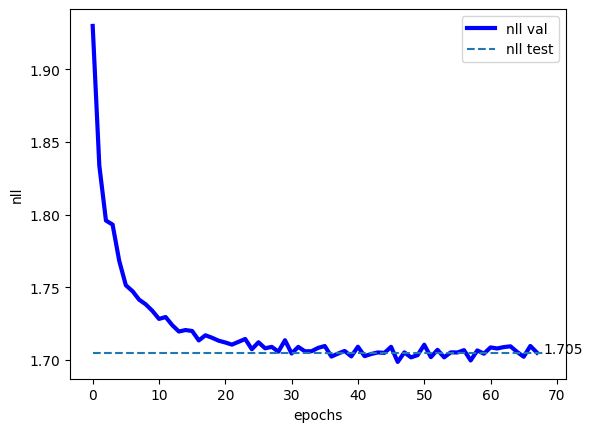

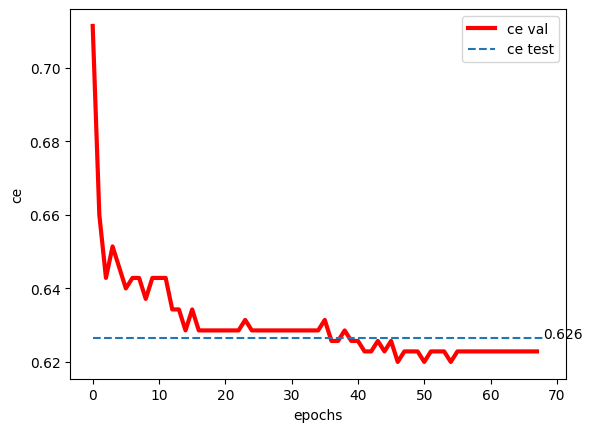


-> START classifier_cnn
Epoch: 0, val nll=1.3229141562325615, val ce=0.44
Epoch: 10, val nll=0.767308088030134, val ce=0.31142857142857144
Epoch: 20, val nll=0.7499615042550223, val ce=0.30857142857142855
Epoch: 30, val nll=0.7579926300048828, val ce=0.3171428571428571
Epoch: 40, val nll=0.745819091796875, val ce=0.3057142857142857
Epoch: 50, val nll=0.7420398221697126, val ce=0.30857142857142855
Epoch: 60, val nll=0.7445565032958984, val ce=0.30857142857142855
Epoch: 70, val nll=0.7393654142107282, val ce=0.30857142857142855
-> FINAL PERFORMANCE: nll=0.823695675638698, ce=0.3288590604026846


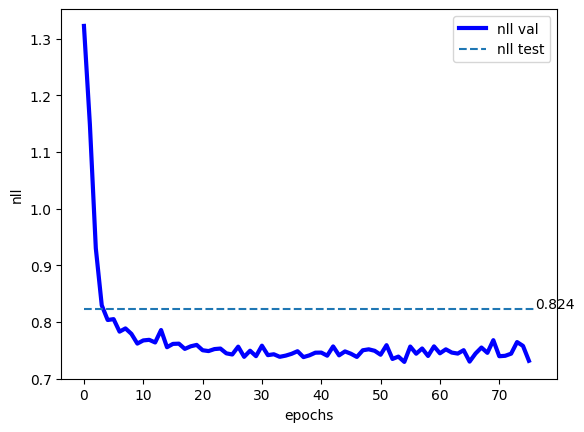

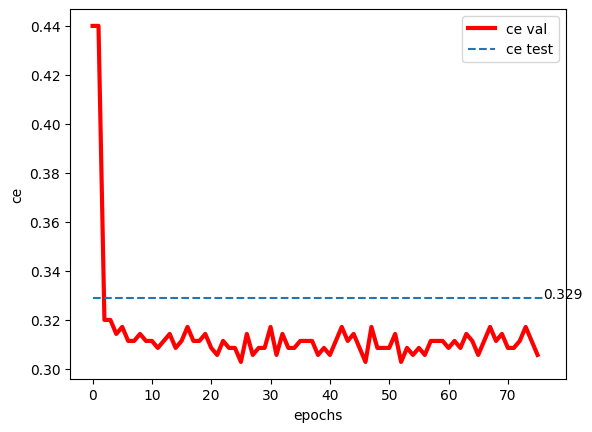

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(nn.Linear(D,M),
                                 nn.ReLU(),
                                 nn.Linear(M,K),
                                 nn.ReLU(),
                                 nn.LogSoftmax(dim=1))
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # The architecture of the MLP:
        # 1 Linear layer with nr of input node 64 and output node 256
        # 1 ReLU
        # 1 Linear layer with nr of input node 256 and output node 10
        # 1 ReLU
        # 1 LogSoftmax
        # ------
        

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(Reshape(size=(1, 8, 8)),
                                 # Input 1x8x8 Output 32x9x9
                                 nn.Conv2d(1,32,kernel_size=(2,2), stride=1, padding=1),
                                 # Input 32x9x9 Output 32x9x9
                                 nn.ReLU(),
                                 # Input 32x9x9 Output 32x9x9
                                 nn.Dropout(0.2),
                                 # Input 32x9x9 Output 64x10x10
                                 nn.Conv2d(32, 64, kernel_size=(2,2), stride=1, padding=1),
                                 # Input 64x10x10 Ouput 64x5x5
                                 nn.MaxPool2d(kernel_size=(2, 2),stride = 2),
                                 # Input 64x5x5 Output 1600
                                 Flatten(),
                                 # Input 1600 Output 512
                                 nn.Linear(1600,512),
                                 # Input 512 Output 512
                                 nn.ReLU(),
                                 # Input 512 Output 512
                                 nn.Dropout(0.2),
                                 # Input 512 Output 10
                                 nn.Linear(512,K),
                                 # Input 10 Output 10
                                 nn.ReLU(),
                                 # Input 10 Output 10
                                 nn.LogSoftmax(dim=1))
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # The architecture of the CNN
        # 1 Reshape to size (1,8,8)
        # 1 Conv2d with 32 output channels
        # 1 ReLU
        # 1 Dropout with p = 0.2
        # 1 Conv2d with 64 output channels
        # 1 MaxPool2d with kernel size = (2,2)
        # 1 Flatten layer
        # 1 Linear layer
        # 1 1 ReLU
        # 1 Dropout with p = 0.2
        # 1 Linear layer 
        # 1 ReLU
        # 1 LogSoftmax
        # ------
        

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: Based on the results, CNN provided a faster convergence then MLP in both negative log likelikhood loss (nllloss) and classification error (ce). Specifically, CNN needed only within 10 epochs to explore the optimum while MLP ran over 40 epochs to reach the best solution. Additionally, CNN provide over 50% improvement in nllloss and ce over MLP.

The results of CNN:

![cnn](https://drive.google.com/uc?export=view&id=1F9MOkLtWOCI5jpGcmOAkrkbJ2vD8qNFm)


The results of MLP:
![mlp](https://drive.google.com/uc?export=view&id=1FotZ7nPnDF557zKsDbHWmZjBHSL8Eg7B)


**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: Definitely, CNN provides a superior performance to MLP in the complicated image processing task. The feasible reason is possibly when the kernel traverses the image, depending on the weights set on the convolutional matrix, the feature map would extract the primary components inside the image, which is not included in the MLP. Besides, the more channels the output has, the more meaningful features are extracted. Thus, CNN processes the image in literally a spatial mean and provide a shorter and better extracted representation for the image when being flattedned. 

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

# Import Library

In [ ]:
# Import library
import scipy  
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid


# Import Dataset
from torchvision.datasets import SVHN

# Create Dataset Class (Step1)

In [ ]:
# This is a class for splitting the Street View House Number dataset of (32px x 32px) digits.
# Version: Cropped images
class StreetView(Dataset):

    def __init__(self, mode="train", transforms=None):

        # import """Pytorch SVHN dataset""" 
        svhn = SVHN(root = results_dir, download = True, split = 'train', transform=ToTensor())

        # load digits would contain some parameter
        if mode == "train":
            # for training
            # take first 60000 images of the train set
            self.data = svhn.data[:60000].astype(np.float32)
            self.targets = svhn.labels[:60000]
        elif mode == "val":
            # for validation
            # take the rest images of the train set
            self.data = svhn.data[60000:].astype(np.float32)
            self.targets = svhn.labels[60000:]
        else:
            # for testing
            # take the whole test set
            test_set = SVHN(root = results_dir, download = True, split = 'test', transform=ToTensor())
            self.data = test_set.data.astype(np.float32)
            self.targets = test_set.labels

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [ ]:
# Initialize training, validation and test sets.
train_data = StreetView(mode="train")
val_data = StreetView(mode="val")
test_data = StreetView(mode="test")

# Initialize data loaders.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


Using downloaded and verified file: /gdrive/MyDrive/Computational Intelligence/train_32x32.mat
Using downloaded and verified file: /gdrive/MyDrive/Computational Intelligence/train_32x32.mat
Using downloaded and verified file: /gdrive/MyDrive/Computational Intelligence/train_32x32.mat
Using downloaded and verified file: /gdrive/MyDrive/Computational Intelligence/test_32x32.mat


**Usage of CUDA**

Due to the high dimensionality and the large volume of images in the dataset, I had to switch all data and models to the CUDA to optimize the training time.

In [ ]:
# The function would prioritize using CUDA
# if it is available
# otherwise, the model is normally trained with CPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


# The function would move all the data structure or model
# under the platform which is processed by the given device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# The new DataLoader 
# which tranforms the normal DataLoader into the loader using the given device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# get device
device = get_default_device()

# change DataLoader type
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1]}")
example = train_data[1][0]
print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: (array([[[ 84.,  86.,  77., ...,  90.,  88.,  88.],
        [ 85.,  83.,  74., ...,  89.,  88.,  88.],
        [ 83.,  78.,  61., ...,  90.,  88.,  85.],
        ...,
        [100.,  98.,  95., ..., 104., 102., 100.],
        [103., 106., 103., ..., 103., 103., 105.],
        [103., 103., 104., ..., 113., 104., 103.]],

       [[ 76.,  73.,  78., ...,  78.,  77.,  78.],
        [ 77.,  73.,  69., ...,  82.,  79.,  81.],
        [ 76.,  77.,  50., ...,  85.,  83.,  82.],
        ...,
        [ 98.,  94.,  93., ..., 104., 102., 101.],
        [104., 104., 103., ..., 104., 103.,  99.],
        [106., 105., 106., ..., 103., 104.,  98.]],

       [[ 59.,  66.,  56., ...,  69.,  67.,  66.],
        [ 61.,  64.,  59., ...,  64.,  70.,  67.],
        [ 60.,  58.,  54., ...,  63.,  66.,  70.],
        ...,
        [ 72.,  76.,  73., ...,  86.,  87.,  78.],
        [ 79.,  79.,  87., ...,  86.,  87.,  81.],
        [ 82.,  87.,  91., .

In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


**Note**:

The input of the dataset is already under the form of an image (3,32,32). It means it has 3 channels for 3 RGB colors and for each channel, it would contain 32x32 pixels. Thus, the model does not need to reshape the input into images.


# Initialize Model (Step 2)

---
The architecture of the 2 phase model:

One 2D Convolutional layer\
One 2D Average Pooling layer\
One 2D Convolutional layer\
One 2D Avergae Pooling layeer\
One Flatten layer\
One Linear layer\
One ReLU activation function\
One Dropout\
One Linear layer\
One ReLU activation function\
One Linear layer\
One ReLU activation function\
One Log Softmax

---





-> START classifier_cnn
Epoch: 0, val nll=2.302585125005451, val ce=0.9337708380478238
Epoch: 10, val nll=2.302585125005451, val ce=0.9337708380478238
Epoch: 20, val nll=2.302585125005451, val ce=0.9337708380478238
Epoch: 30, val nll=1.7075435602171276, val ce=0.6336275175379045
Epoch: 40, val nll=1.3299319073113864, val ce=0.45440144829146867
Epoch: 50, val nll=0.8563217483351311, val ce=0.2299162706494682
Epoch: 60, val nll=0.7877921365348158, val ce=0.21490533303160594
Epoch: 70, val nll=0.8924352214681155, val ce=0.21716828845138417
-> FINAL PERFORMANCE: nll=0.8773744279208473, ce=0.23659342347879533


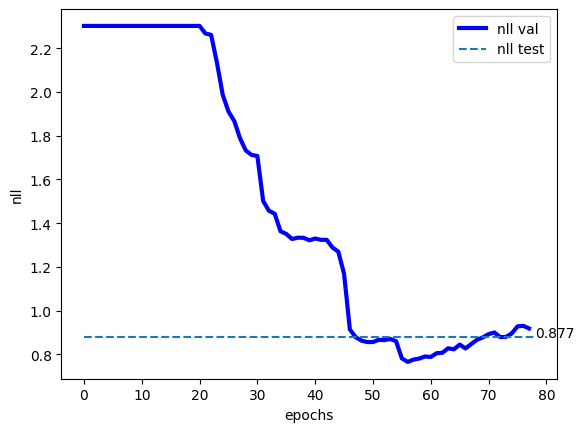

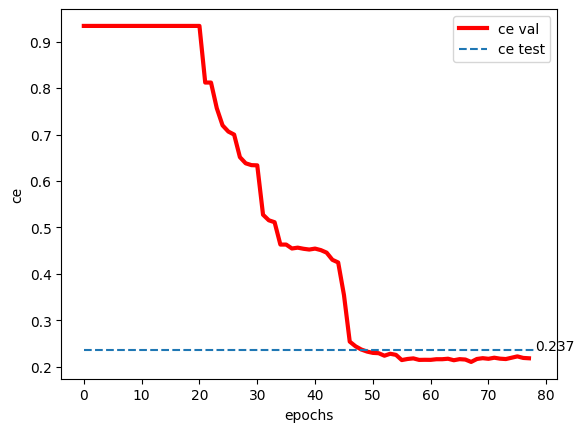

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run one models: CNN
names = ["classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(nn.Flatten(),
                                 nn.Linear(3072,512),
                                 nn.ReLU(),
                                 nn.Linear(512,1024),
                                 nn.ReLU(),
                                 nn.Linear(1024,2048),
                                 nn.ReLU(),
                                 nn.Linear(2048,10),
                                 nn.LogSoftmax(dim=1))
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        classnet = nn.Sequential(nn.Conv2d(3,64,kernel_size=(2,2), stride=2),
                                 
                                 nn.AvgPool2d(kernel_size=(2,2), stride=1),
                                 
                                 nn.Conv2d(64, 128, kernel_size=(2,2), stride=2),
                                 
                                 nn.AvgPool2d(kernel_size=(2,2),stride = 1),
                                
                                 nn.Flatten(),
                                 
                                 nn.Linear(4608,512),
                                 
                                 nn.ReLU(),
                                 
                                 nn.Dropout(0.2),
                                 
                                 nn.Linear(512,1024),
                                 
                                 nn.ReLU(),

                                 nn.Linear(1024,K),

                                 nn.ReLU(),
                                 
                                 nn.LogSoftmax(dim=1))
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)
    to_device(model, device)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=train_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

# Additional Components (Step 3)

Beside the significant Convolutional layer, we also add a **Dropout layer** in the feature extraction phase. The setting of the layer is p = 0.2. It means that for each time the kernel traverse the image, each weight in the convolutional matrix would be dropped out randomly with the probability of 20%. Since the dataset of 32x32 images is so far complicated if we take all pixels under consideration and it costs an expensive price for the GPU. Thus, the application of Dropout would simpler the computation at some extent and reduce overfitiing or generalise the model in the broader range.

# Explanation (Step 4)
First, the architecture comprise a Convolution layer with the number of input channels is 3, number of output channels is 64, kernel size is (2,2), and the stride step is 2. Therefore, the outcomes would contain 64 new features. Following that, an average pooling layer is applied to take the average value inside a neighbour of a square of 4 pixels (kernel size = (2,2)). Second, another Convolution layer is arranged with the aim to extract more feature inside the image. The layer accepts 64 channels and releases 128 channels with the same setting for kernel size and stride step as the first convolutional layer. Repetitively, a similar average pooling is included. 

After the feature extraction, we would flatten the image into a single tensor for the classification task. The prevailing 1D tensor would comprise of 4608 elements and the first hidden layer would compress them into 512 nodes. Then a ReLU non-linear activation function is applied with setting as deafult. Besides, we also drop some weights of the model to lower the cost of computation. The probability of a weight to being dropped is p = 0.2. Next, 2 set of hidden layer followed by a ReLU activation function are established, which would return a tensor of 10 elements, which match the number of classes in the dataset. Definitely, the outcome would come over the Log SoftMax to be backpropagated by the Negative Log likelihood loss. The dimension to compute the log probabilities is 1 because the input of the model is a full batch of 54 images and the first dimension is 64 (size of batch, not size of image).



# Analysis (Step 5)
In overall, the model is impossible to reach at most 0.1 ce as expectation but the outome is still acceptable with ce in test set 0.237. Due to the complication of images (subject, background, noice), it takes much many epochs to acquire the optimal solution (more than 50 epochs). Another point is that within the first 20 epochs, it is no any improvement, it means the model did learn nothing from the dataset. Thus, it created a waste in computational usage in training. Futhermore, the negative log likelihood loss showed an impressive figure, which is 0.8077 in the test set, which is far improved from the first task. 

However, the preprocessing for the images is not optimal, it creates a inconsistency between some images whose objects have high value and background has low value and other images having the inverse content. Consequently, the application of min or max pooling is not suitable in that sense. In the future, we shoud apply the filter that can recognition the objects out of the background and set them as the same setiting. Consequently, we can decrease the irreducible error for the classification.

The results:\
![shvn](https://drive.google.com/uc?export=view&id=17JUNwiZ1wS_F697RJ_4FvTIgsP4tirln)